In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

## Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
import os
DATA_TRAIN_PATH = 'train.csv' # TODO: download train data and supply path here 
y, tX, ids, headers = load_csv_data(DATA_TRAIN_PATH) # Modified the load_csv_data to also give headers

In [3]:
print(y.shape)
print(tX.shape)

(250000,)
(250000, 30)


In [4]:
headers.shape

(30,)

## Exploratory Data Analysis

It seems like missing values are equal to -999 in the dataset. Let's count how many there are in each feature:

In [5]:
count_missing = np.count_nonzero(tX == -999, axis=0)
print(count_missing)
cols_missing = np.where(count_missing != 0)
print(cols_missing)

[ 38114      0      0      0 177457 177457 177457      0      0      0
      0      0 177457      0      0      0      0      0      0      0
      0      0      0  99913  99913  99913 177457 177457 177457      0]
(array([ 0,  4,  5,  6, 12, 23, 24, 25, 26, 27, 28], dtype=int64),)


Eleven of the 30 features have a significant amount of -999 values. However, they seem to be linked as they all have similar quantities. From the information document, here are there causes:

Column 0 (DER_mass_MMC) - Undefined if the topology of the event is too far from the expected topology \
Column 4 (DER_deltaeta_jet_jet) - undefined if PRI_jet_num ≤ 1 \
Column 5 (DER_mass_jet_jet) - undefined if PRI_jet_num ≤ 1 \
Column 6 (DER_prodeda_jet_jet) - undefined if PRI_jet_num ≤ 1 \
Column 12 (DER_lep_eta_centrality - undefined if PRI_jet_num ≤ 1 \
Column 23 (PRI_jet_leading_pt) - undefined if PRI_jet_num = 0 \
Column 24 (PRI_jet_leading_eta) - undefined if PRI_jet_num = 0 \
Column 25 (PRI_jet_leading_phi) - undefined if PRI_jet_num = 0 \
Column 26 (PRI_jet_subleading_pt) - undefined if PRI_jet_num ≤ 1 \
Column 27 (PRI_jet_subleading_eta) - undefined if PRI_jet_num ≤ 1 \
Column 28 (PRI_jet_subleading_phi) - undefined if PRI_jet_num ≤ 1  

Other than the first column, the other missing values are all based on the PRI_jet_num.

First, we will look at the distributions of the columns without missing values.

In [6]:
cols_missing[0][1:]

array([ 4,  5,  6, 12, 23, 24, 25, 26, 27, 28], dtype=int64)

In [7]:
# create reduced tX. We leave the first column even if it has missing values.

tX_red = tX.copy()
tX_red = np.delete(tX_red, cols_missing[0][1:], axis = 1)
headers_red = headers.copy()
headers_red = np.delete(headers_red, cols_missing[0][1:])
tX_red.shape

(250000, 20)

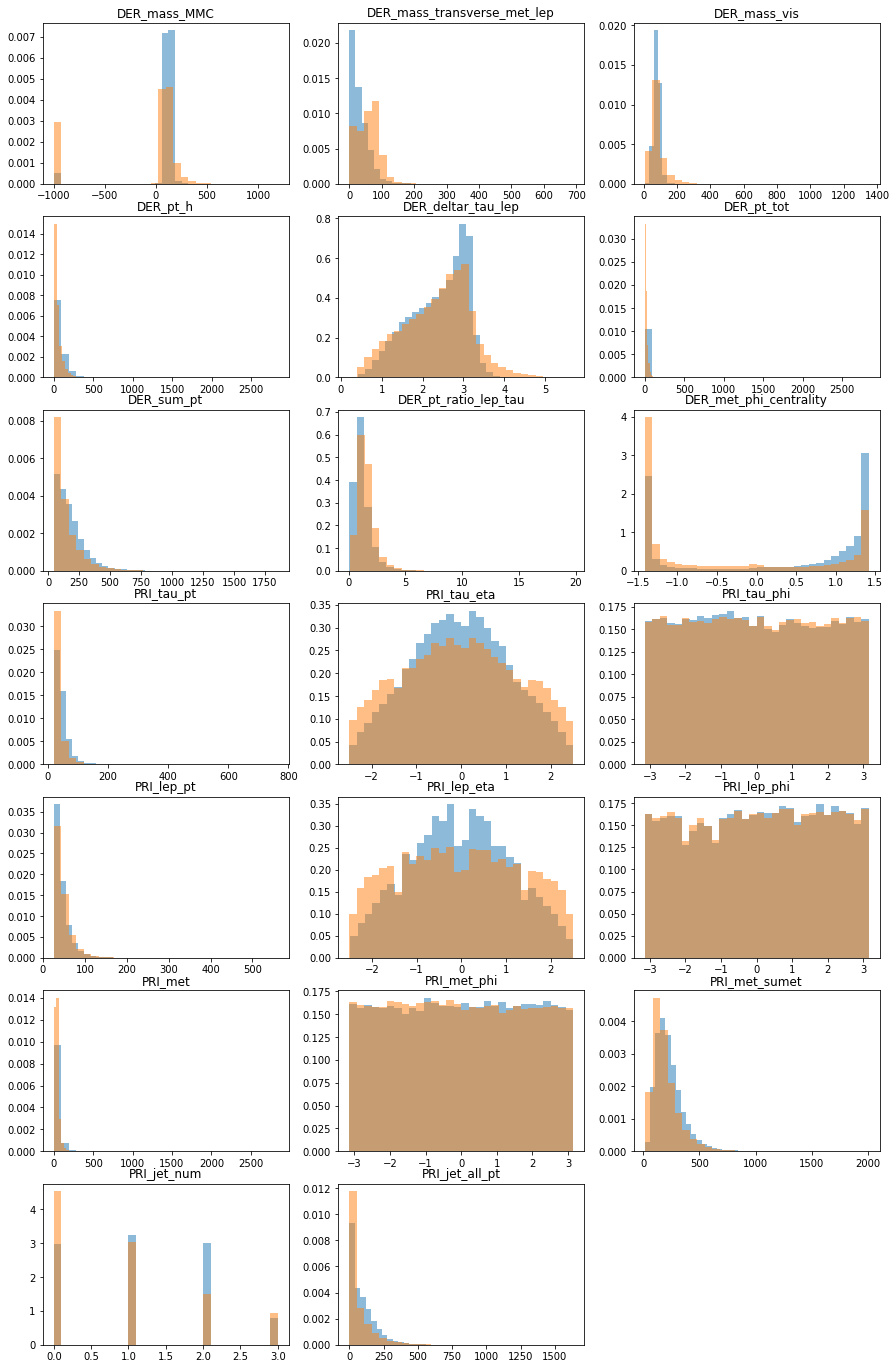

In [9]:
fig = plt.figure(figsize = (15,35))
for i in range(tX_red.shape[1]):
    ax = fig.add_subplot(10,3, i+1)
    plt.hist(tX_red[y == 1, i], 30, alpha = 0.5, density = True)
    plt.hist(tX_red[y == -1, i], 30, alpha = 0.5, density = True)
    plt.title(headers_red[i])

The first column has many missing values, but the distributions between the two classes are different and therefore this feature may be valuable. We will need to find a way to keep this feature.

Now, let's look at the distributions of the columns with missing values. (while ignoring the -999 datapoints)

In [10]:
np.where(headers == 'PRI_jet_num')

(array([22], dtype=int64),)

In [8]:
jet0inds = np.where(tX[:,22] == 0)
jet1inds = np.where(tX[:,22] == 1)
jet2inds = np.where(tX[:,22] == 2)
jet3inds = np.where(tX[:,22] == 3)

# Jet num = 1
tx_1 = tX.copy()
tx_1 = tx_1[np.concatenate([jet2inds[0],jet3inds[0]]),:]
y_1 = y.copy()
y_1 = y_1[np.concatenate([jet2inds[0],jet3inds[0]])]

# Jet num = 2 and 3
tx_2 = tX.copy()
tx_2 = tx_2[np.concatenate([jet2inds[0],jet3inds[0]]),:]
y_2 = y.copy()
y_2 = y_2[np.concatenate([jet2inds[0],jet3inds[0]])]

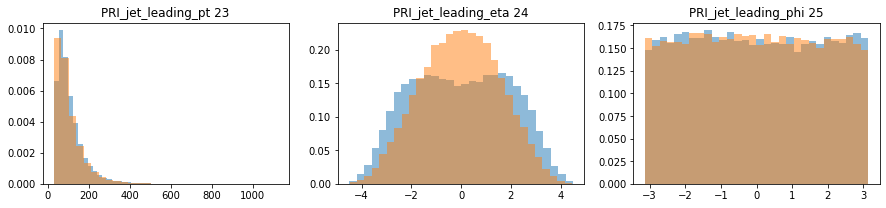

In [12]:
# Distributions of jet 1
fig = plt.figure(figsize = (15,35))
j=0
for i in [23, 24, 25]:
    ax = fig.add_subplot(10,3, j+1)
    plt.hist(tx_1[y_1 == 1, i], 30, alpha = 0.5, density = True)
    plt.hist(tx_1[y_1 == -1, i], 30, alpha = 0.5, density = True)
    plt.title(headers[i] + " " + str(i))
    j=j+1

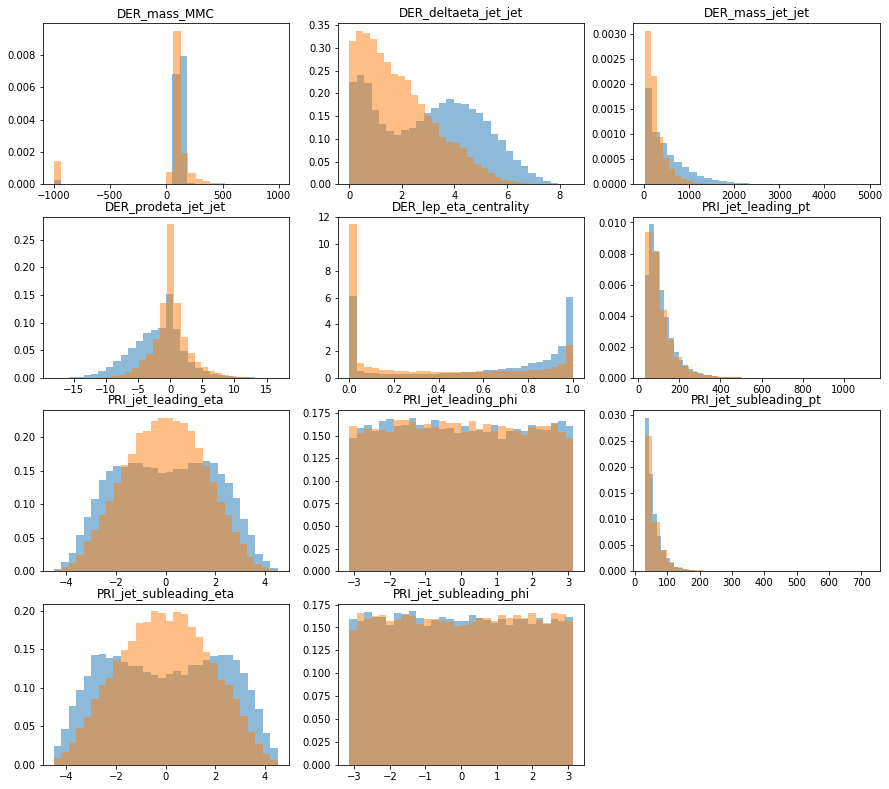

In [13]:
# Distributions of jets 2 and 3
fig = plt.figure(figsize = (15,35))
j=0
for i in cols_missing[0]:
    ax = fig.add_subplot(10,3, j+1)
    plt.hist(tx_2[y_2 == 1, i], 30, alpha = 0.5, density = True)
    plt.hist(tx_2[y_2 == -1, i], 30, alpha = 0.5, density = True)
    plt.title(headers[i])
    j=j+1

Some of these features seem important. While the two ending in _phi do not seem very useful. 

This leads us to believe that we will need to keep these features for the datapoints where they are not missing.

Let us look for any outliers in the data using boxplots.

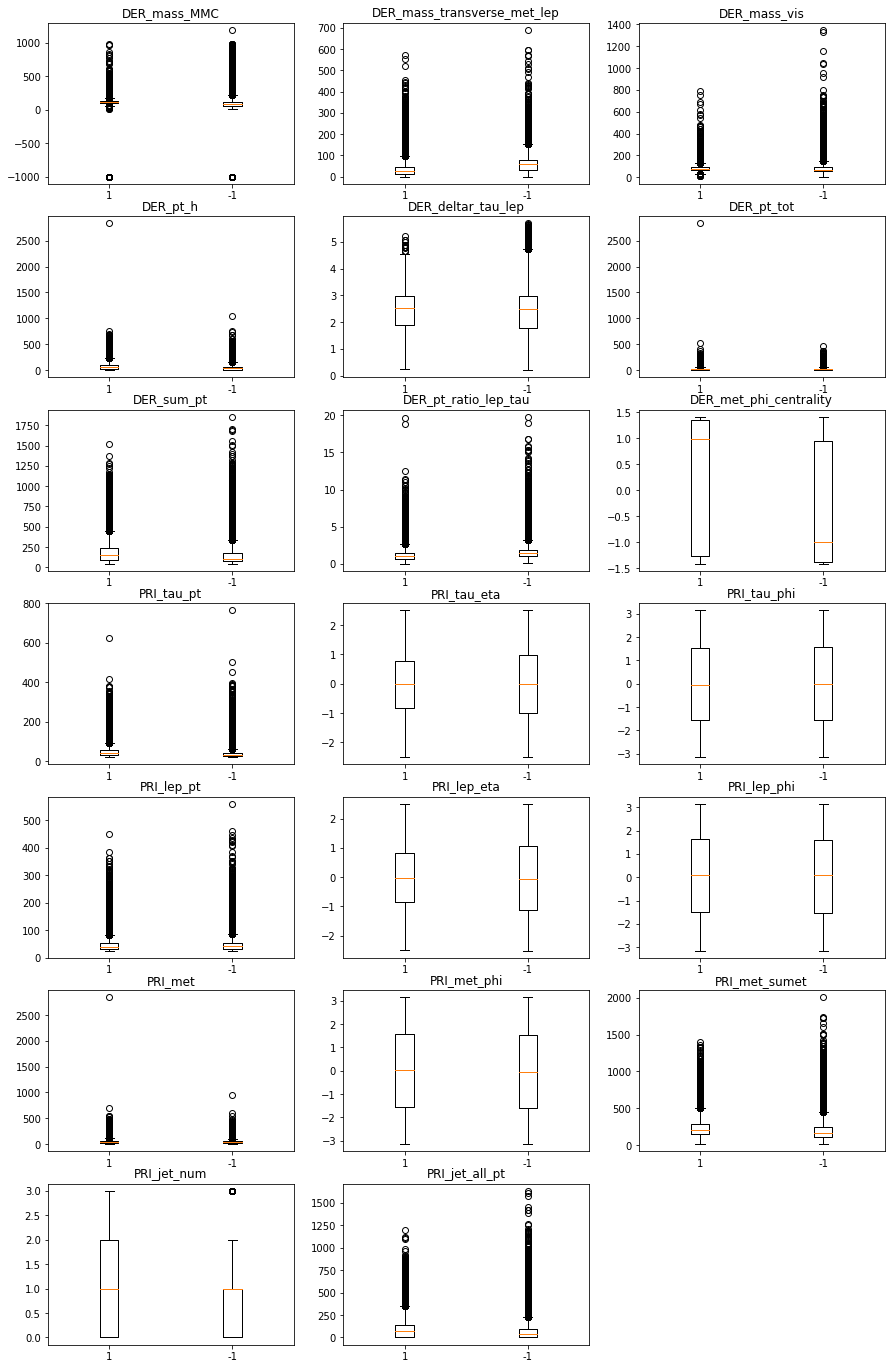

In [14]:
fig = plt.figure(figsize = (15,35))
for i in range(tX_red.shape[1]):
    ax = fig.add_subplot(10,3, i+1)
    boxes = [tX_red[y == 1, i], tX_red[y == -1, i]]
    plt.boxplot(boxes, labels = [1, -1])
    plt.title(headers_red[i])

There is a clear outlier in features 3, 5 and 15. However, there are also many outliers in the other features. We will need to deal with these eventually. For now, let's look at the other features with jet=1 and jet=2,3

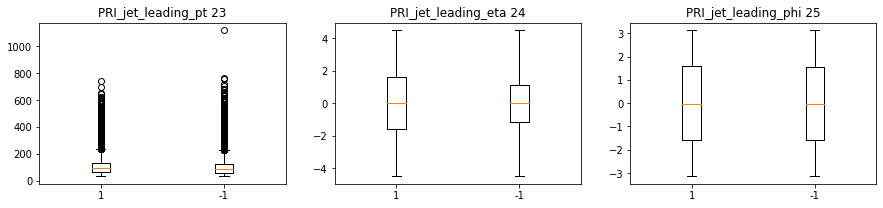

In [15]:
fig = plt.figure(figsize = (15,35))
j=0
for i in [23, 24, 25]:
    ax = fig.add_subplot(10,3, j+1)
    boxes = [tx_1[y_1 == 1, i], tx_1[y_1 == -1, i]]
    plt.boxplot(boxes, labels = [1, -1])
    plt.title(headers[i] + " " + str(i))
    j=j+1

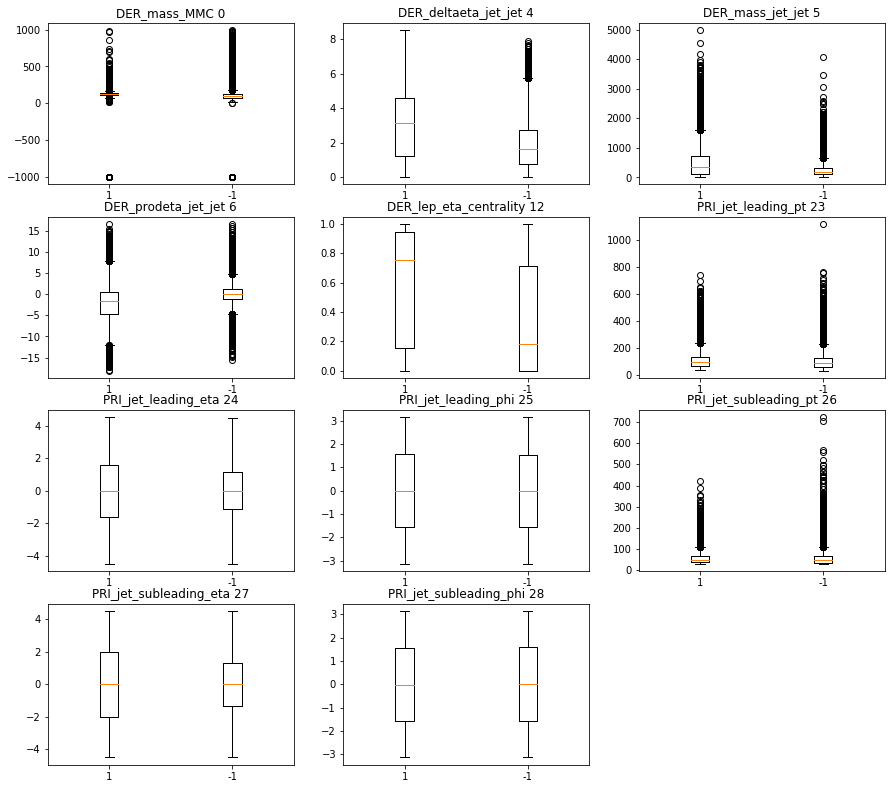

In [16]:
fig = plt.figure(figsize = (15,35))
j=0
for i in cols_missing[0]:
    ax = fig.add_subplot(10,3, j+1)
    boxes = [tx_2[y_2 == 1, i], tx_2[y_2 == -1, i]]
    plt.boxplot(boxes, labels = [1, -1])
    plt.title(headers[i] + " " + str(i))
    j=j+1

Again, there are many outliers here.

## Feature Processing

In [9]:
np.where(headers == 'PRI_jet_num')

(array([22], dtype=int64),)

As we have seen in our EDA, the many missing values can be attributed to the PRI_jet_num variable (col 22). Therefore, we will split our training data into three separate sets: 

- 1 with all missing value columns removed
- 1 with all PRI_jet_num = 1 (remove cols# 4, 5, 6, 12, 26, 27, 28) 
- 1 with all PRI_jet_num=2,3 (keep all columns)

But first, we will remove the columns that showed little or no difference in distributions between the classes. These are: PRI_jet_leading_phi, PRI_jet_subleading_phi, PRI_tau_phi, PRI_met_phi, PRI_lep_phi

In [10]:
cols_remove = []
cols_remove.append(np.where(headers == "PRI_jet_leading_phi")[0])
cols_remove.append(np.where(headers == "PRI_jet_subleading_phi")[0])
cols_remove.append(np.where(headers == "PRI_tau_phi")[0])
cols_remove.append(np.where(headers == "PRI_met_phi")[0])
cols_remove.append(np.where(headers == "PRI_lep_phi")[0])

tx_ = tX.copy() # create copy of original data
head_  = headers.copy()
tx_ = np.delete(tx_, cols_remove, axis = 1)
head_ = np.delete(head_, cols_remove)
tx_.shape

(250000, 25)

Now, for the first feature, if has some undefined values, but also contains useful information. The missing values here are not attributed to the jet number. We will replace the missing values with the mean of the others.

In [11]:
inds_missing = np.where(tx_[:,0] == -999) 
inds_good = np.delete(np.arange(tx_.shape[0]), inds_missing)
mean_ = np.mean(tx_[inds_good, 0])  # caluclate the mean using only non-missing values
tx_[inds_missing, 0] = mean_        # replace all missing values with the mean

In [12]:
tx_.shape

(250000, 25)

Next, we must take the categorical variable (PRI_jet_num) and split it into separate columns with only 1s and 0s. We do not want one category to be considered more important because it is labeled with a higher number.

We must decompose the categorical data by one hot encoding them into more features.

In [13]:
# The possible entries of feature PRI_jet_num are 0, 1, 2, 3
col = np.where(head_=='PRI_jet_num')[0]
inds0 = np.where(tx_[:, col] == 0)[0]
inds1 = np.where(tx_[:, col] == 1)[0]
inds2 = np.where(tx_[:, col] == 2)[0]
inds3 = np.where(tx_[:, col] == 3)[0]

# initialize new columns as zeros
pri_jet0 = np.zeros(tx_.shape[0])
pri_jet1 = np.zeros(tx_.shape[0])
pri_jet2 = np.zeros(tx_.shape[0])
pri_jet3 = np.zeros(tx_.shape[0])

# set ones to appropriate columns
pri_jet0[inds0] = 1
pri_jet1[inds1] = 1
pri_jet2[inds2] = 1
pri_jet3[inds3] = 1

# test it
print(tx_[:10,19])
print(pri_jet0[:10])
print(pri_jet1[:10])
print(pri_jet2[:10])
print(pri_jet3[:10])

[2. 1. 1. 0. 0. 3. 2. 1. 0. 1.]
[0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
[0. 1. 1. 0. 0. 0. 0. 1. 0. 1.]
[1. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Now we will standardize all columns before appending our jet number columns

In [14]:
tx_.shape

(250000, 25)

In [15]:
# standardize all columns
from implementations import standardize

tx_ = standardize(tx_)

# delete original jet_num column
tx_ = np.delete(tx_, col, axis=1)
head_ = np.delete(head_, col)
new_heads = ['pri_jet_num0', 'pri_jet_num1', 'pri_jet_num2', 'pri_jet_num3']

# append new columns
tx_ = np.column_stack((tx_,pri_jet0, pri_jet1, pri_jet2, pri_jet3))
head_ = np.append(head_, new_heads)

# add bias term at beginning
tx_ = np.c_[np.ones((tx_.shape[0], 1)), tx_]
head_ = np.append(['bias'], head_)


Now, we will split the tx_ into the three sets as described before

In [16]:
tx_[0,:]

array([ 1.        ,  0.31491066,  0.06833197,  0.40768027, -0.46996624,
        1.56075342,  1.10331316,  1.57172801,  0.88247762,  1.03309853,
        0.33989441,  0.17092875,  1.27708372,  1.56347384, -0.2708107 ,
        0.84671212,  0.22505416,  1.81228807, -0.75675685,  0.38684673,
        0.78010211,  0.82030188,  1.53882556,  1.5668    ,  0.4125105 ,
        0.        ,  0.        ,  1.        ,  0.        ])

In [17]:
tx_0 = tx_.copy()
tx_1 = tx_.copy()
tx_2 = tx_.copy()

# Features to remove for reduced tx_ 
cols_remove0 = []
cols_remove0.append(np.where(head_ == "DER_deltaeta_jet_jet")[0][0])
cols_remove0.append(np.where(head_ == "DER_mass_jet_jet")[0][0])
cols_remove0.append(np.where(head_ == "DER_prodeta_jet_jet")[0][0])
cols_remove0.append(np.where(head_ == "DER_lep_eta_centrality")[0][0])
cols_remove0.append(np.where(head_ == "PRI_jet_leading_pt")[0][0])
cols_remove0.append(np.where(head_ == "PRI_jet_leading_eta")[0][0])
cols_remove0.append(np.where(head_ == "PRI_jet_subleading_pt")[0][0])

# features to remove for tx_1 (jet#=1)
cols_remove1 = []
cols_remove1.append(np.where(head_ == "DER_deltaeta_jet_jet")[0])
cols_remove1.append(np.where(head_ == "DER_mass_jet_jet")[0])
cols_remove1.append(np.where(head_ == "DER_prodeta_jet_jet")[0])
cols_remove1.append(np.where(head_ == "DER_lep_eta_centrality")[0])
cols_remove1.append(np.where(head_ == "PRI_jet_subleading_pt")[0])

# remove features
tx_0 = np.delete(tx_0, cols_remove0, axis=1)
tx_1 = np.delete(tx_1, cols_remove1, axis=1)

# filter tx_1 and tx_2 to keep only relevant jet#s
tx_1 = tx_1[inds1, :]
inds23 = np.append(inds2, inds3)
tx_2 = tx_2[inds23, :]


We now have 3 datasets:
 - tx_0: all datapoints, all cols with -999 removed
 - tx_1: only jet#=1, all remaining cols with -999 removed
 - tx_2: only jet#=2,3 no columns removed

# Logistic Regression Implementation

In [33]:
from implementations import *
from proj1_helpers import *

In [25]:
y01 = y.copy()
y01[ y01 < 0] = 0

# test it
print(y[:10])
print(y01[:10])

[ 1. -1. -1. -1. -1. -1.  1.  1. -1.  1.]
[1. 0. 0. 0. 0. 0. 1. 1. 0. 1.]


In [26]:
def logistic_regression_demo(y, tx, max_iters, gamma):
    """polynomial regression with different split ratios and different degrees."""
    w_init = np.ones((tx_0.shape[1], 1))
    
    x_train, y_train, x_test, y_test = split_data(tx, y, ratio=0.8, seed=1)
    
    w_, loss_tr = logistic_regression(y, tx, w_init, max_iters, gamma)
    
    # modified helper functions returns 0 or 1
    pred = predict_labels01(w_, x_test)

    error_te = 0
    for i in range(y_test.shape[0]):
            error = np.abs(y_test[i] - pred[i])
            error_te = error_te + error    
   
    print('Proportion test error: ', error_te/y_test.shape[0])
    
    return w_

In [27]:
# run logistic regression
w_ = logistic_regression_demo(y01,tx_0, max_iters=200, gamma=0.01)

Current iteration=0, training loss=[716428.31687454]
Current iteration=100, training loss=[612522.44648644]
Current iteration=199, training loss=[522516.54047635]
Proportion test error:  [0.4335]


# Regularized Logistic Regression Implementation

In [34]:
def reg_logistic_regression_demo(y, tx, lambda_, max_iters, gamma):
    """polynomial regression with different split ratios and different degrees."""
    w_init = np.ones((tx_0.shape[1], 1))
    
    x_train, y_train, x_test, y_test = split_data(tx, y, ratio=0.8, seed=1)
    
    w_, loss_tr = reg_logistic_regression(y, tx, lambda_, w_init, max_iters, gamma)
    
    # modified helper functions returns 0 or 1
    pred = predict_labels01(w_, x_test)

    error_te = 0
    for i in range(y_test.shape[0]):
            error = np.abs(y_test[i] - pred[i])
            error_te = error_te + error    
   
    print('Proportion test error: ', error_te/y_test.shape[0])
    
    return w_

In [35]:
# run REG logistic regression
gamma = 0.02
max_iter = 200
lambda_ = 0
w_ = reg_logistic_regression_demo(y01, tx_0, lambda_, max_iters=200, gamma=0.01)

Current iteration=0, training loss=[716428.31687454]
Current iteration=100, training loss=[612522.44648644]
Current iteration=199, training loss=[522516.54047635]
Proportion test error:  [0.4335]


# Functions

1) least_squares_GD(y, tx, initial_w,max_iters, gamma)

2) least_squares_SGD(y, tx, initial_w,max_iters, gamma)

3) least_squares(y, tx)

4) ridge_regression(y, tx, lambda_)

5) logistic regression(y, tx, initial_w, max_iters, gamma)

6) reg_logistic_regression(y, tx, lambda_,initial_w, max_iters, gamma)

## Generate predictions and save ouput in csv format for submission:

In [10]:
DATA_TEST_PATH = '' # TODO: download train data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [31]:
OUTPUT_PATH = '' # TODO: fill in desired name of output file for submission
y_pred = predict_labels(weights, tX_test)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)